In [22]:
!pip install transformers sentence_transformers seaborn umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
!pip3 install pickle5

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Loading the models

In [24]:
labels = ['Macroeconomía','Regulaciones','Innovación','Alianza','Sostenibilidad','Descartable']

In [25]:
SIMILARITY_TRAINED = True

from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
model_name = 'hiiamsid/sentence_similarity_spanish_es'

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [26]:
from sentence_transformers import InputExample

if SIMILARITY_TRAINED:
  model = SentenceTransformer(model_name)
else:
  model = AutoModel.from_pretrained(model_name)




## Loading the triples from the pickle

In [27]:
import pickle5 as pickle

with open('../input/fewshotdataton/few_shot_pairs.pickle', 'rb') as f:
    pickle_obj = pickle.load(f)

In [28]:
train_examples = [] 

for pair in pickle_obj['pairs']: 
    train_examples.append(InputExample(texts=[pair['anchor'], pair['positive'], pair['negative']]))

                                              
sizes = {}
category_sentences = [] 

for label in labels: 
    sizes[label] = len([pair for pair in pickle_obj['pairs'] if pair['label'] == label])
    category_sentences.append([pair['anchor'] for pair in pickle_obj['pairs'] if pair['label'] == label])

In [29]:
sizes

{'Macroeconomía': 72,
 'Regulaciones': 39,
 'Innovación': 39,
 'Alianza': 0,
 'Sostenibilidad': 14,
 'Descartable': 14}

In [30]:
sizes[labels[0]]

72

## Generating the embeddings

In [31]:
import torch
import numpy as np
import itertools
texts = list(itertools.chain(*category_sentences))
# len_test_sentences = len(list(itertools.chain(*test_sentences)))

if SIMILARITY_TRAINED:
  embeddings = model.encode(texts)
else:
  tokens = tokenizer(texts)
  max_len = max([len(i) for i in tokens['input_ids']])
  tokens_input_ids_padded = [list(token_input_id) + [tokenizer.pad_token_id]*(max_len-len(token_input_id)) for token_input_id in tokens['input_ids']]
  attention_masks_padded = [list(attention_mask) + [0]*(max_len-len(attention_mask)) for attention_mask in tokens['attention_mask']]
  embeddings = model(torch.tensor(tokens_input_ids_padded, dtype=torch.long, device=torch.device('cpu')), \
                     attention_mask=torch.tensor(attention_masks_padded, dtype=torch.long, device=torch.device('cpu'))).last_hidden_state[:,0,:].detach().numpy()




Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [32]:
import umap
reducer = umap.UMAP()
embed_2d = reducer.fit_transform(embeddings)
import matplotlib.pyplot as plt
import seaborn as sns


In [33]:
len(embed_2d[:, 0])

178

## Plotting the embeddings based on each label

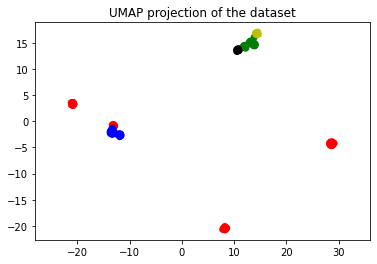

In [34]:
plt.scatter(
    embed_2d[:, 0],
    embed_2d[:, 1],
    c = ['r']*sizes[labels[0]]+ ['b']*sizes[labels[1]]+['g']*sizes[labels[2]]+['m']*sizes[labels[3]]+['y']*sizes[labels[4]]+['k']*sizes[labels[5]],
    marker='o')
# plt.scatter(
#     embed_2d[-len_test_sentences:, 0],
#     embed_2d[-len_test_sentences:, 1],
#     c = ['r']*len(test_sports_sentences)+['b']*len(test_economics_sentences)+['g']*len(test_environment_sentences),
#     marker='*')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset');

## TripletLoss

In [35]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=1)
from sentence_transformers import losses
train_loss = losses.TripletLoss(model=model)
num_epochs = 5
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1) #10% of train data

In [37]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          optimizer_params={'lr': 5e-05}) 

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/178 [00:00<?, ?it/s]

Iteration:   0%|          | 0/178 [00:00<?, ?it/s]

Iteration:   0%|          | 0/178 [00:00<?, ?it/s]

Iteration:   0%|          | 0/178 [00:00<?, ?it/s]

Iteration:   0%|          | 0/178 [00:00<?, ?it/s]

In [38]:
import torch
import numpy as np
import itertools
texts = list(itertools.chain(*category_sentences))
# len_test_sentences = len(list(itertools.chain(*test_sentences)))

if SIMILARITY_TRAINED:
  embeddings = model.encode(texts)
else:
  tokens = tokenizer(texts)
  max_len = max([len(i) for i in tokens['input_ids']])
  tokens_input_ids_padded = [list(token_input_id) + [tokenizer.pad_token_id]*(max_len-len(token_input_id)) for token_input_id in tokens['input_ids']]
  attention_masks_padded = [list(attention_mask) + [0]*(max_len-len(attention_mask)) for attention_mask in tokens['attention_mask']]
  embeddings = model(torch.tensor(tokens_input_ids_padded, dtype=torch.long, device=torch.device('cpu')), \
                     attention_mask=torch.tensor(attention_masks_padded, dtype=torch.long, device=torch.device('cpu'))).last_hidden_state[:,0,:].detach().numpy()




Batches:   0%|          | 0/6 [00:00<?, ?it/s]

## TripletLoss cluster plotting

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


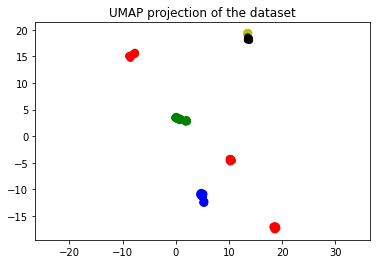

In [39]:
import umap
reducer = umap.UMAP()
embed_2d = reducer.fit_transform(embeddings)
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(
    embed_2d[:, 0],
    embed_2d[:, 1],
    c = ['r']*sizes[labels[0]]+ ['b']*sizes[labels[1]]+['g']*sizes[labels[2]]+['m']*sizes[labels[3]]+['y']*sizes[labels[4]]+['k']*sizes[labels[5]],
    marker='o')
# plt.scatter(
#     embed_2d[-len_test_sentences:, 0],
#     embed_2d[-len_test_sentences:, 1],
#     c = ['r']*len(test_sports_sentences)+['b']*len(test_economics_sentences)+['g']*len(test_environment_sentences),
#     marker='*')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset');